## Описание проекта

### Проект "Прогнозирование температуры звезды"

Нам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. 
<br>
Обычно для расчёта температуры учёные пользуются следующими методами:
<br>Закон смещения Вина.
<br>Закон Стефана-Больцмана.
<br>Спектральный анализ.
<br>Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

## Загрузка данных

In [1]:
# Загрузим необходимые библиотеки
!pip install scikit-learn==1.1.3 -q
!pip -q install phik
!pip install category_encoders

In [2]:
# Импортируем необходимые нам библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

# снимим ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

In [3]:
# Загрузим данные /datasets/6_class.csv. 
# Ознакомимся с содержимым.
data = pd.read_csv('/datasets/6_class.csv')
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


Данные загрузились корректно. Информация по 240 звездам, по 6 признакам. Явных пропусков в данных нет. Тип данных определился верно.

У нас есть описание предоставленных для проекта данных:
<br>Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах (наш целевой признак).
<br>Относительная светимость L/Lo — светимость звезды относительно Солнца.
<br>Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
<br>Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
<br>Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
<br>Тип звезды, где номер, соответствует типу:
    <br>Коричневый карлик	0
    <br>Красный карлик	1
    <br>Белый карлик	2
    <br>Звёзды главной последовательности	3
    <br>Сверхгигант	4
    <br>Гипергигант	5
<br><br>
Столбец 'Unnamed: 0' - это прежний индекс датасета, у нас создан новый при загрузке, так что можем старый удалить.

In [4]:
# Удалим старый индекс и выведем информацию о распределении признаков
data = data.drop(columns='Unnamed: 0')
data.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


## Предобработка и анализ данных

Предобработку и анализ данных начнем с числовых признаков.

In [5]:
# Создадим функцию вывода гистограммы распределения для числовых данных
def hist_num (df, col, title, label, bins):
    plt.figure(figsize=(10, 6))
    df[col].plot(kind = 'hist', grid=True, bins=bins)
    plt.title(f'{title}')
    plt.ylabel('Частота')
    plt.xlabel(f'{label}')
    plt.show()
    display(df[col].describe())

Сперва целевой признак 'Temperature (K)'

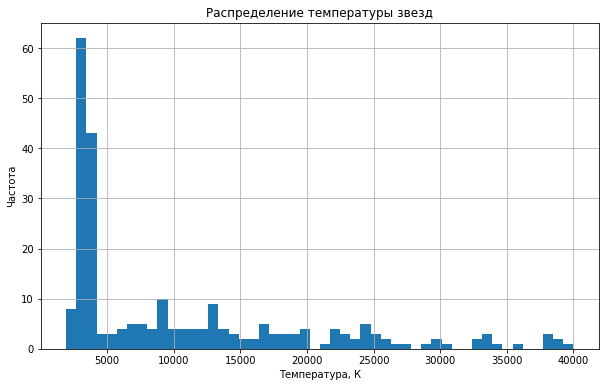

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: Temperature (K), dtype: float64

In [6]:
# Выведем диаграмму распределения температуры звезд 
df=data
col='Temperature (K)'
title='Распределение температуры звезд'
label='Температура, К'
bins=50
hist_num(df, col, title, label, bins)

В датасете преобладают относительно холодные звезды с температурой 3000-4000 К (как у ламп с "теплым" светом). Большего про целевой признак отметить нечего. Продолжим анализ остальных числовых признаков.

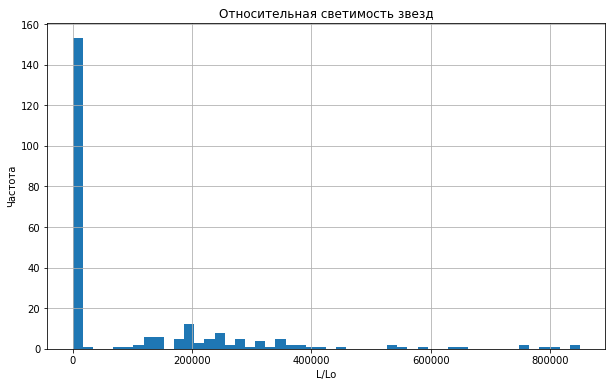

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: Luminosity(L/Lo), dtype: float64

In [7]:
# Выведем диаграмму распределения относительной светимости звезды относительно Солнца 
df=data
col='Luminosity(L/Lo)'
title='Относительная светимость звезд'
label='L/Lo'
bins=50
hist_num(df, col, title, label, bins)

Распределение демонстрирует существенную несбалансированность по данному признаку.

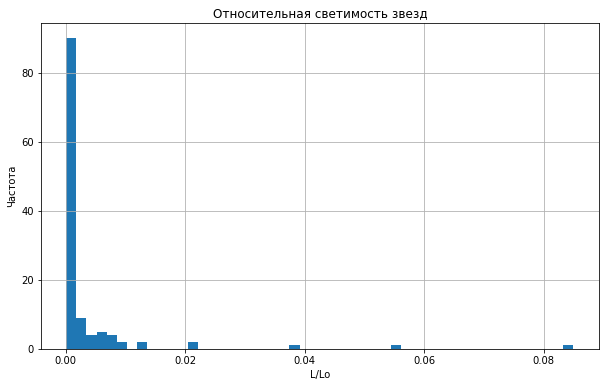

count    121.000000
mean       0.003523
std        0.010154
min        0.000080
25%        0.000437
50%        0.000870
75%        0.001800
max        0.085000
Name: Luminosity(L/Lo), dtype: float64

In [8]:
# Выведем диаграмму распределения с минимальной относительной светимости
df=data[data['Luminosity(L/Lo)'] < 0.1]
col='Luminosity(L/Lo)'
title='Относительная светимость звезд'
label='L/Lo'
bins=50
hist_num(df, col, title, label, bins)

121 звезда из 240 имеют светимость менее 0.1 относительно Солнца. Еще одно свидетельство несбалансированности в характеристиках звезд. Отметим это и продолжим.

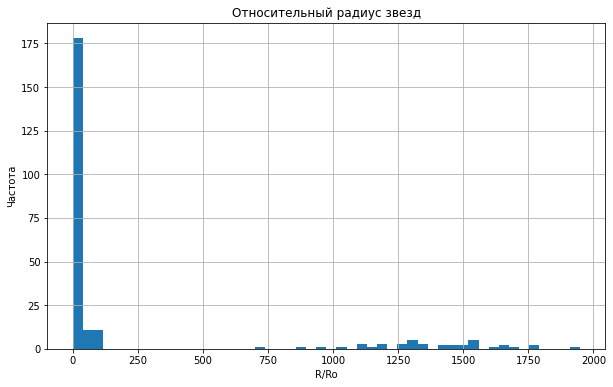

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: Radius(R/Ro), dtype: float64

In [9]:
# Выведем диаграмму распределения относительного радиуса R/Ro звезд относительно радиуса Солнца 
df=data
col='Radius(R/Ro)'
title='Относительный радиус звезд'
label='R/Ro'
bins=50
hist_num(df, col, title, label, bins)

Та же история с несбалансированностью датасета, значительная часть звезд имеют минимальный радиус.

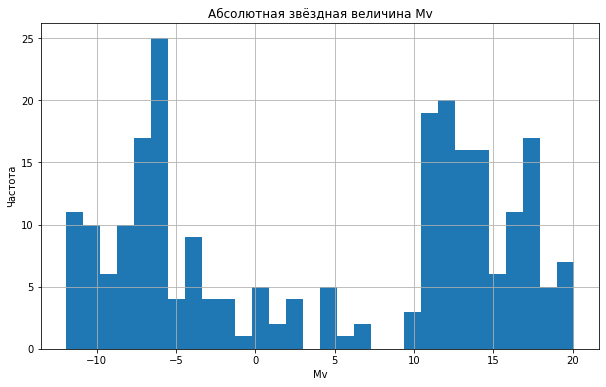

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: Absolute magnitude(Mv), dtype: float64

In [10]:
# Выведем диаграмму распределения абсолютной звёздной величины, Mv 
df=data
col='Absolute magnitude(Mv)'
title='Абсолютная звёздная величина Mv'
label='Mv'
bins=30
hist_num(df, col, title, label, bins)

Распределение отдаленно похожее на бимодальное, с отрицательным Mv и положительным Mv. Далее на очереди категориальные признаки.

In [11]:
# Создадим функцию вывода круговой диаграммы для категориальных данных
def pie_cat (df, col, title, label):
    group_tab = df.groupby(col).size()/len(df)
    group_tab = group_tab.sort_values(ascending=True)
    group_tab.plot(kind='pie', autopct = '%1.0f%%', normalize=False)
    plt.title(f'{title}')
    plt.ylabel(f'{label}')
    plt.show() 

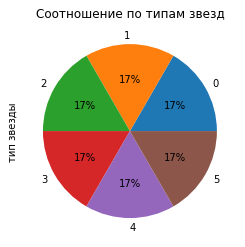

In [12]:
# Выведем диаграмму соотношения по типам звезд
df=data
col='Star type'
title='Соотношение по типам звезд'
label='тип звезды'
pie_cat(df, col, title, label)

Распределение указывает на равные доли типов звезд в датасете. Посмотрим звездный свет.

Тут неожиданное разнообразие цветов. Диаграмма не может отразить его полностью, но видны явные опечатки и дублирования в названии цветов. Воспользуемся табличным представлением данных.

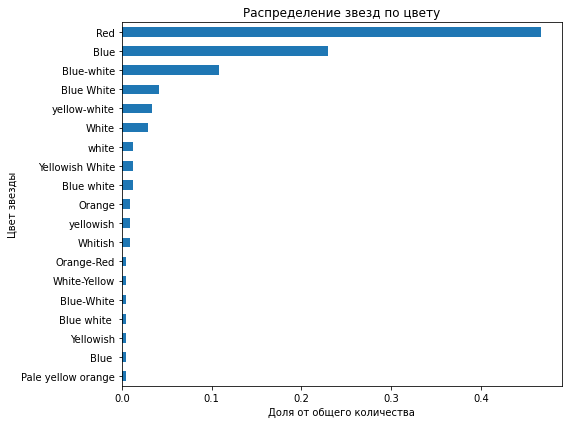

In [13]:
# Выведем диаграмму соотношения по звездному свету
group_tab = data.groupby('Star color').size()/len(data)
group_tab = group_tab.sort_values(ascending=True)
plt.figure(figsize=(8, 6))
group_tab.plot(kind='barh')
plt.title('Распределение звезд по цвету')
plt.xlabel('Доля от общего количества')
plt.ylabel('Цвет звезды')
plt.tight_layout()
plt.show()


In [14]:
# Выведем список уникальных значений звездных цветов
data['Star color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Orange                  2
yellowish               2
Whitish                 2
Yellowish               1
Pale yellow orange      1
Blue-White              1
Blue white              1
White-Yellow            1
Orange-Red              1
Blue                    1
Name: Star color, dtype: int64

In [15]:
# Приведем все цвета к нижнему регистру, уберем пробелы. Для удаления дублирования объединим по оттенкам.
data['Star color'] = data['Star color'].replace('Red', 'red')
data['Star color'] = data['Star color'].replace(('Blue', 'Blue '), 'blue')
data['Star color'] = data['Star color'].replace(('Blue White', 'Blue white', 'Blue-white', 'Blue white ', 'Blue-White'), 'blue_white')
data['Star color'] = data['Star color'].replace('White', 'white')
data['Star color'] = data['Star color'].replace('Whitish', 'whitish')
data['Star color'] = data['Star color'].replace(('Yellowish White', 'yellow-white', 'White-Yellow'), 'yellow_white')
data['Star color'] = data['Star color'].replace('Yellowish', 'yellowish')
data['Star color'] = data['Star color'].replace('Orange-Red', 'orange_red')
data['Star color'] = data['Star color'].replace('Pale yellow orange','pale_yellow_orange')
data['Star color'] = data['Star color'].replace('Orange', 'orange')


In [16]:
# Выведем список уникальных значений звездных цветов после обработки
data['Star color'].value_counts()

red                   112
blue                   56
blue_white             41
yellow_white           12
white                  10
yellowish               3
orange                  2
whitish                 2
orange_red              1
pale_yellow_orange      1
Name: Star color, dtype: int64

Теперь с звездным цветом у нас порядок. Для корреляционного анализа воспользуемся матрицей корреляции.

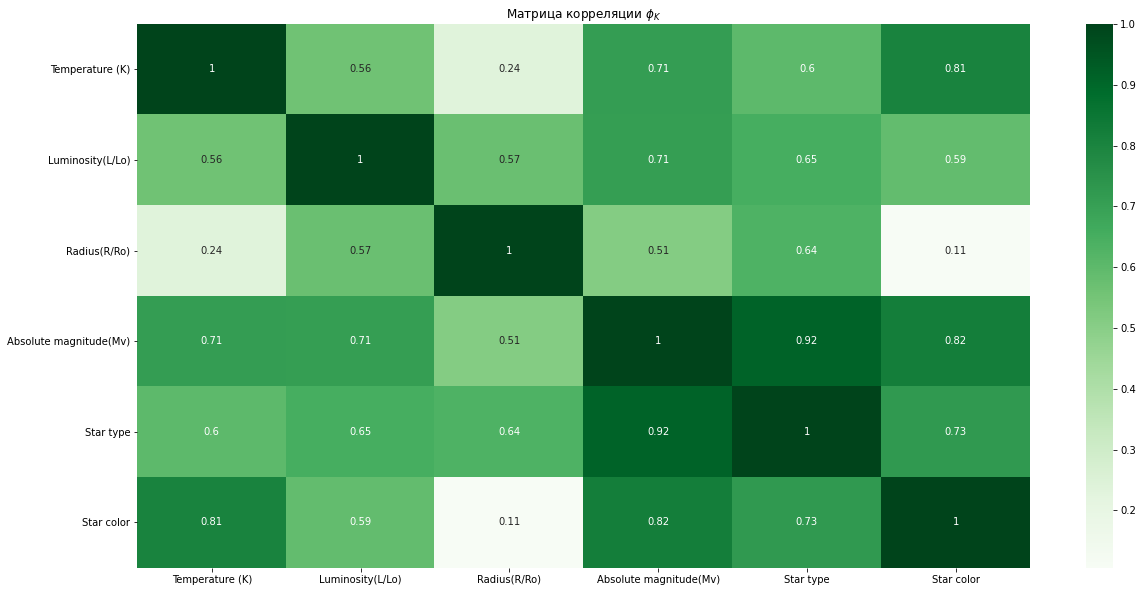

In [17]:
# Обозначим количественные признаки для матрицы
interval_cols = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

# Выведем матрицу корреляции
target_matrix = data.phik_matrix(interval_cols = interval_cols)
plt.figure(figsize=(20, 10))
sns.heatmap(target_matrix, annot=True, cmap='Greens')
plt.title('Матрица корреляции $\phi_K$')
plt.show()

In [18]:
# Выделим и отсортируем коэффициенты корреляции с нашим целевым признаком
target_matrix['Temperature (K)'].sort_values(ascending=False)

Temperature (K)           1.000000
Star color                0.806195
Absolute magnitude(Mv)    0.710472
Star type                 0.603924
Luminosity(L/Lo)          0.562667
Radius(R/Ro)              0.236637
Name: Temperature (K), dtype: float64

Наилучшую корреляцию с целевым признаком 'Temperature (K)' имеет 'Star color'. Признаки 'Absolute magnitude(Mv)', 'Star type' и 'Luminosity(L/Lo)' тоже имеют устойчивую связь с 'Temperature (K)'.
<br>
Для себя отметим во первых, что 'Star color' имеет очевидную иерархическую связь по видимому спектру излучения с температурой (известное физическое явление). И поэтому кодироваться будет с помощью OrdinalEncoder с передачей иерархии списком.
<br>
Во вторых, 'Star type' хоть и категориальный признак, но уже по сути закодирован в числовом виде и с корректной иерархией, что подтверждается отличной корреляцией (с коэф. 0.92) с признаком 'Absolute magnitude(Mv)'. Поэтому не будем его кодировать, в сеть он пойдет в неизменном виде.

In [19]:
# Выведем медианные значения температуры по цветам звезд для составления корректного списка для OrdinalEncoder
grouped = data.groupby('Star color')['Temperature (K)'] \
    .agg('median') \
    .sort_values(ascending=False) 
grouped

Star color
blue                  19921.5
blue_white            14100.0
white                  8879.5
whitish                8876.0
pale_yellow_orange     7230.0
yellow_white           6928.5
orange_red             5112.0
yellowish              4526.0
orange                 4018.0
red                    3324.0
Name: Temperature (K), dtype: float64

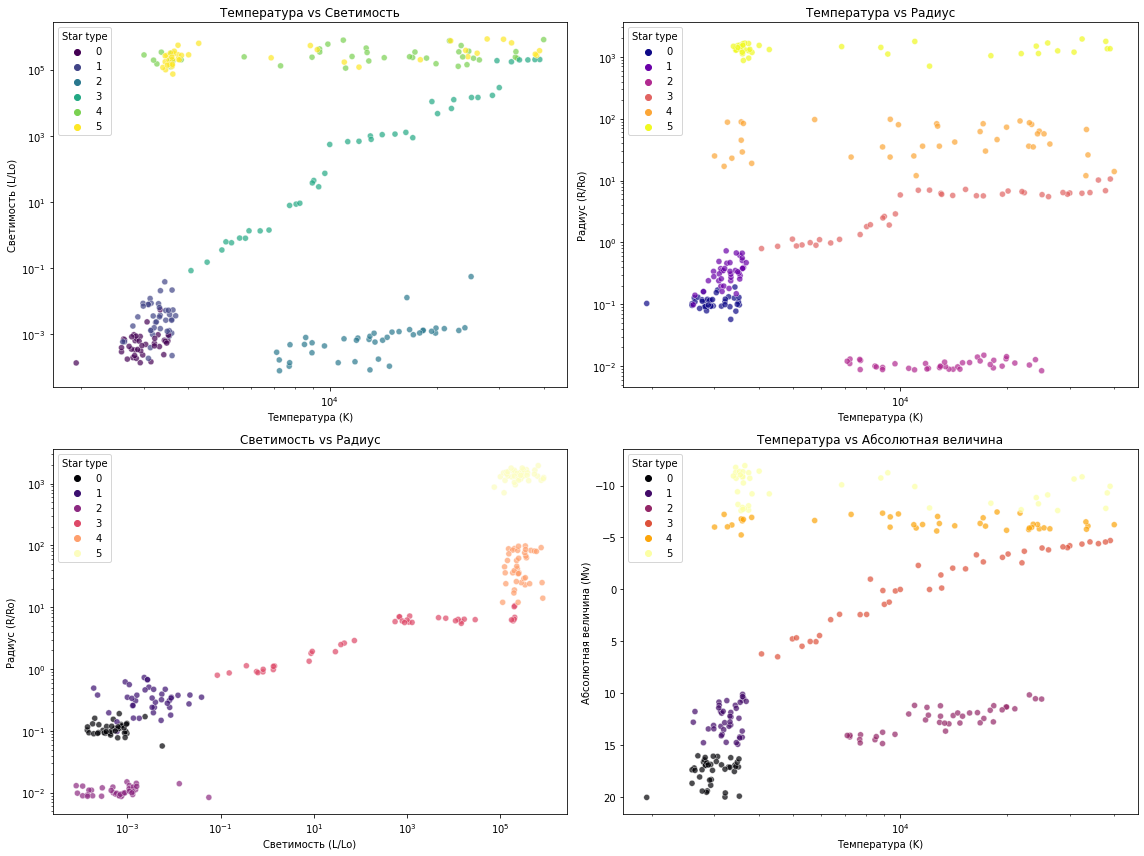

In [20]:
# Выведем диаграммы рассеивания, разделив цветом звезды по типу 
plt.figure(figsize=(16, 12))

# График 1: Температура vs Светимость
plt.subplot(2, 2, 1)
sns.scatterplot(data=data, 
                x='Temperature (K)', 
                y='Luminosity(L/Lo)', 
                hue='Star type', 
                palette='viridis',
                alpha=0.7)
plt.title('Температура vs Светимость')
plt.xscale('log')  # Используем логарифмический масштаб
plt.yscale('log')
plt.xlabel('Температура (K)')
plt.ylabel('Светимость (L/Lo)')

# График 2: Температура vs Радиус
plt.subplot(2, 2, 2)
sns.scatterplot(data=data, 
                x='Temperature (K)', 
                y='Radius(R/Ro)', 
                hue='Star type', 
                palette='plasma',
                alpha=0.7)
plt.title('Температура vs Радиус')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Температура (K)')
plt.ylabel('Радиус (R/Ro)')

# График 3: Светимость vs Радиус
plt.subplot(2, 2, 3)
sns.scatterplot(data=data, 
                x='Luminosity(L/Lo)', 
                y='Radius(R/Ro)', 
                hue='Star type', 
                palette='magma',
                alpha=0.7)
plt.title('Светимость vs Радиус')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Светимость (L/Lo)')
plt.ylabel('Радиус (R/Ro)')

# График 4: Абсолютная величина vs Температура
plt.subplot(2, 2, 4)
sns.scatterplot(data=data, 
                x='Temperature (K)', 
                y='Absolute magnitude(Mv)', 
                hue='Star type', 
                palette='inferno',
                alpha=0.7)
plt.title('Температура vs Абсолютная величина')
plt.xscale('log')
plt.gca().invert_yaxis()  # Инвертируем ось Y для величины
plt.xlabel('Температура (K)')
plt.ylabel('Абсолютная величина (Mv)')

plt.tight_layout()
plt.show()

Диаграммы рассеивания демонстрируют различия в свойствах звезд в зависимости от их типа, явно локализуя на графиках отдельные типы. 

## Построение базовой нейронной сети

Подготовим тренировочные и тестовые выборки. Преобразуем их в тензоры.

In [21]:
# Подготовим выборки для обучения моделей

# Разделим датасет на входные признаки и целевой
X = data.drop('Temperature (K)', axis=1)
y = data['Temperature (K)']

#categorical_cols = ['Star type', 'Star color']

#X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Разделим данные на тренировочные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Кодирование OrdinalEncoder для 'Star color'
categorical_cols = ['Star color']
# Создадим категориальный последовательный список 
colors = ['red', 'orange_red', 'orange', 'pale_yellow_orange', 'yellowish', 'yellow_white', 'white', 'whitish', 'blue_white', 'blue']

# Применяем OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[colors])

# Применим кодирование к тренировочной выборке
X_train[categorical_cols] = ordinal_encoder.fit_transform(X_train[categorical_cols])

# Применим то же кодирование к тестовой выборке
X_test[categorical_cols] = ordinal_encoder.transform(X_test[categorical_cols])

# Стандартизируем числовые признаки
numerical_cols = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
scaler = StandardScaler()

# Применим масштабирование к тренировочной выборке
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# Применим то же масштабирование к тестовой выборке
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Преобразуем в тензоры наши выборки
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

В качетсве базовой нейронной сети выберем полносвязную сеть с двумя скрытыми слоями с 8-ю и 5-ю нейронами. 

In [22]:
X_train.shape[1]

5

In [23]:
# Зададим количество нейронов в слоях
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 8
n_hidden_neurons_2 = 5
n_out_neurons = 1

In [24]:
# Создадим класс и архитектуру нейронной сети
class NeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x

In [25]:
# Инициализируем модель, зададим оптимизацию и функцию потерь
net = NeuralNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3)
loss = nn.MSELoss()

In [26]:
# Инициализируем начальные веса и смещения
def init_weights(layer):
    if type(layer) == nn.Linear: # Проверка, что слой – полносвязный
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

net.apply(init_weights)

NeuralNet(
  (fc1): Linear(in_features=5, out_features=8, bias=True)
  (ac1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=8, out_features=5, bias=True)
  (ac2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
  (ac3): LeakyReLU(negative_slope=0.01)
)

In [27]:
# Запустим цикл обучения

num_epochs = 10001

for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    
    preds = net.forward(X_train).flatten()    
    
    # Регуляризация весов
    #l1_lambda = 0.0005
    #l1_norm = sum(p.abs().sum() for p in net.parameters())
    l2_lambda = 0.01
    l2_norm = sum(p.pow(2.0).sum() for p in net.parameters())
    loss_value = torch.sqrt(loss(preds, y_train)) + l2_lambda * l2_norm #+ l1_lambda * l1_norm
    loss_value.backward()

    optimizer.step()

    if epoch % 1000 == 0:
        net.eval()
        y_pred = net.forward(X_test).flatten()
        print('Epoch #:', epoch)
        print('RMSE =', torch.sqrt(loss(y_pred, y_test)).item(), '\n')
   

Epoch #: 0
RMSE = 14625.48828125 

Epoch #: 1000
RMSE = 8015.13427734375 

Epoch #: 2000
RMSE = 5872.34423828125 

Epoch #: 3000
RMSE = 5672.89404296875 

Epoch #: 4000
RMSE = 5484.7822265625 

Epoch #: 5000
RMSE = 5288.9345703125 

Epoch #: 6000
RMSE = 5108.53759765625 

Epoch #: 7000
RMSE = 4831.93310546875 

Epoch #: 8000
RMSE = 4584.49658203125 

Epoch #: 9000
RMSE = 4303.6416015625 

Epoch #: 10000
RMSE = 4068.40869140625 



In [28]:
# Функция для построения графика
def plot_results(y_test, y_pred):
    n = len(y_test)
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n+1), y_pred.detach().numpy(), color='orange', label='Прогноз')
    plt.bar(range(1, n+1), y_test.detach().numpy(), color='blue', width=0.5, label='Факт')
    
    plt.title('Сравнение фактических и предсказанных температур звезд')
    plt.xlabel('Номер звезды в таблице данных')
    plt.ylabel('Температура (K)')
    plt.legend()
    plt.grid()
    plt.show()



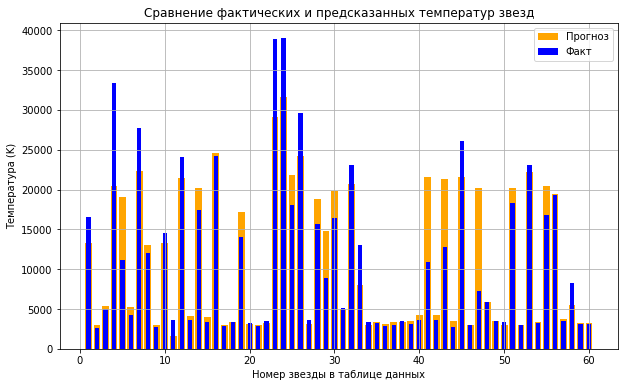

In [29]:
# Выведем график сравнения результатов
plot_results(y_test, y_pred)

Базовая модель реализована, результаты демонстрируют наличие потенциала в ее улучшении. Метрика RMSE на 9000-й эпохе составила 4303.6 К. На графике сравнения видно, что диапазоне низких температур модель хорошо работает, затем в среднем диапазоне начинает завышать, а в области высоких значений - занижать температуру звезд относительно факта. 

## Улучшение нейронной сети

В качестве направлений для улучшения качества нейронной сети применим методы Dropout и Batch sizes с перебором гиперпараметров.

In [30]:
# Функция для обеспечения воспроизводимости
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # для multi-GPU.
    np.random.seed(seed)  # для numpy
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Устанавливаем seeds
set_seeds()

# Обновленная архитектура с Dropout
class NeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons, dropout_rate):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x

# Параметры для перебора
dropout_values = [0.0, 0.2, 0.4]
batch_sizes = [30, 60, 90]

# results для сохранения результатов
results = []

# Перебор параметров
for dropout in dropout_values:
    for batch_size in batch_sizes:
        print(f"\nTraining with Dropout: {dropout}, Batch Size: {batch_size}")
        
        # Инициализация модели
        n_in_neurons = X_train.shape[1]
        n_hidden_neurons_1 = 8
        n_hidden_neurons_2 = 5
        n_out_neurons = 1
        
        net = NeuralNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout)
        optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, weight_decay=0.01)
        loss = nn.MSELoss()
        
        # Инициализация весов
        def init_weights(layer):
            if type(layer) == nn.Linear:
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
        
        net.apply(init_weights)
        
        # Обучение
        num_epochs = 10001
        train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id))
        
        for epoch in range(num_epochs):
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                preds = net.forward(batch_x).flatten()
                loss_value = loss(preds, batch_y)
                                          
                loss_value.backward()
                optimizer.step()
            
            
            if epoch % 1000 == 0:
                net.eval()
                y_pred = net.forward(X_test).flatten()
                current_rmse = torch.sqrt(loss(y_pred, y_test)).item()
                print(f'Epoch #: {epoch}, RMSE = {current_rmse}')

            # После обучения сохраняем результаты
            final_rmse = torch.sqrt(loss(y_pred, y_test)).item()
            results.append({
                'dropout': dropout,
                'batch_size': batch_size,
                'final_rmse': final_rmse,
                'y_pred': y_pred  # Сохраняем предсказания
            })

            

# Выводим таблицу результатов
results_df = pd.DataFrame(results)

# Находим лучшие параметры и соответствующие предсказания
best_params = results_df.loc[results_df['final_rmse'].idxmin()]
best_y_pred = best_params['y_pred']

print("\nЛучшие параметры:")
print(f"Dropout: {best_params['dropout']}")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Достигнутый RMSE: {best_params['final_rmse']:.2f}")


Training with Dropout: 0.0, Batch Size: 30
Epoch #: 0, RMSE = 14625.3681640625
Epoch #: 1000, RMSE = 5670.55908203125
Epoch #: 2000, RMSE = 5514.99267578125
Epoch #: 3000, RMSE = 5317.376953125
Epoch #: 4000, RMSE = 5121.21533203125
Epoch #: 5000, RMSE = 4919.35693359375
Epoch #: 6000, RMSE = 4729.779296875
Epoch #: 7000, RMSE = 4549.17333984375
Epoch #: 8000, RMSE = 4448.29443359375
Epoch #: 9000, RMSE = 4351.6435546875
Epoch #: 10000, RMSE = 4269.478515625

Training with Dropout: 0.0, Batch Size: 60
Epoch #: 0, RMSE = 14621.806640625
Epoch #: 1000, RMSE = 5833.724609375
Epoch #: 2000, RMSE = 5618.384765625
Epoch #: 3000, RMSE = 5467.4501953125
Epoch #: 4000, RMSE = 5317.111328125
Epoch #: 5000, RMSE = 5161.529296875
Epoch #: 6000, RMSE = 5005.5830078125
Epoch #: 7000, RMSE = 4798.7958984375
Epoch #: 8000, RMSE = 4603.15966796875
Epoch #: 9000, RMSE = 4456.8876953125
Epoch #: 10000, RMSE = 4406.798828125

Training with Dropout: 0.0, Batch Size: 90
Epoch #: 0, RMSE = 14626.3232421875


In [31]:
# Веведем сводную таблицу с лучшими результатами для каждой комбинации
pivot_table = results_df.pivot_table(
    index='dropout', 
    columns='batch_size', 
    values='final_rmse', 
    aggfunc='min'
)
styled_pivot = pivot_table.style.background_gradient(
    cmap='Greys_r',  # цветовая карта
    axis=None,       # применять ко всей таблице
    vmin=pivot_table.min().min(),  # минимальное значение
    vmax=pivot_table.max().max()   # максимальное значение
)
styled_pivot

batch_size,30,60,90
dropout,,,
0.0,4269.478516,4406.798828,4862.828613
0.2,4261.169922,5085.376465,5281.218750
0.4,4254.614258,5270.336426,4966.381836


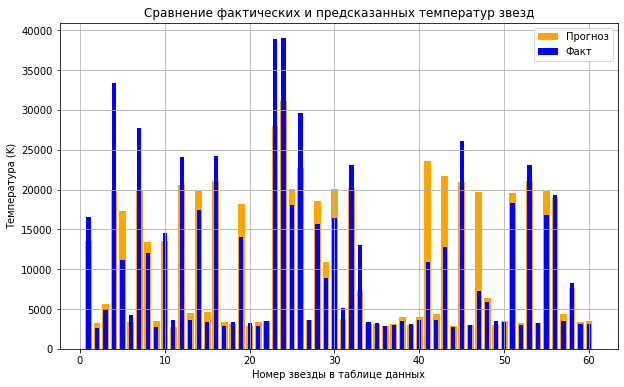

In [32]:
# Выведем график сравнения результатов лучшей нейронной сети по результатам перебора гиперпараметров
plot_results(y_test, best_y_pred)

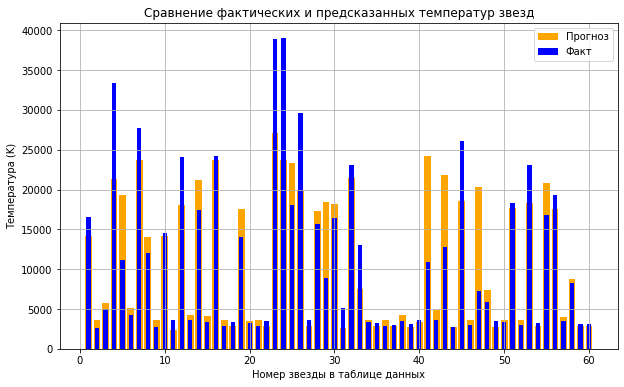

In [33]:
# Выведем график сравнения результатов базовой нейронной сети
plot_results(y_test, y_pred)

По результатам перебора гиперпараметров
dropout_values = [0.0, 0.2, 0.4]
batch_sizes = [30, 60, 90]
<br>Лучшие параметры оказались при:
<br>Dropout: 0.4
<br>Batch Size: 30
<br>Достигнутый RMSE: 4254.6
<br><br>
В таблице с результатами видно, что наилучшие метрики у batch_sizes = 30, dropout_values в свою очередь не меняет существенно качество нейронной сети.
<br><br>
При сравнении на графиках заметно незначительное улучшение в прогнозировании, наличие потенциала по улучшению тоже просматривается. Добавим нормализацию батчей в скрытые слои нейронной сети и посмотрим что получится.

In [34]:
# Функция для обеспечения воспроизводимости
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # для multi-GPU.
    np.random.seed(seed)  # для numpy
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Устанавливаем seeds
set_seeds()

# Обновленная архитектура с Dropout и Batch Normalization
class NeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons, dropout_rate):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(hidden_neurons_1)  # Добавляем BatchNorm после первого слоя
        self.ac1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(hidden_neurons_2)  # Добавляем BatchNorm после второго слоя
        self.ac2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # Применяем BatchNorm
        x = self.ac1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)  # Применяем BatchNorm
        x = self.ac2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.ac3(x)
        return x

# Параметры для перебора
dropout_values = [0.0, 0.2, 0.4]
batch_sizes = [30, 60, 90]

# results для сохранения результатов
results = []

# Перебор параметров
for dropout in dropout_values:
    for batch_size in batch_sizes:
        print(f"\nTraining with Dropout: {dropout}, Batch Size: {batch_size}")
        
        # Инициализация модели
        n_in_neurons = X_train.shape[1]
        n_hidden_neurons_1 = 8
        n_hidden_neurons_2 = 5
        n_out_neurons = 1
        
        net = NeuralNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout)
        optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, weight_decay=0.01)
        loss = nn.MSELoss()
        
        # Инициализация весов
        def init_weights(layer):
            if type(layer) == nn.Linear:
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
        
        net.apply(init_weights)
        
        # Обучение
        num_epochs = 10001
        train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id))
        
        for epoch in range(num_epochs):
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                preds = net.forward(batch_x).flatten()
                loss_value = loss(preds, batch_y)
                                          
                loss_value.backward()
                optimizer.step()
            
            
            if epoch % 1000 == 0:
                net.eval()
                y_pred = net.forward(X_test).flatten()
                current_rmse = torch.sqrt(loss(y_pred, y_test)).item()
                print(f'Epoch #: {epoch}, RMSE = {current_rmse}')

            # После обучения сохраняем результаты
            final_rmse = torch.sqrt(loss(y_pred, y_test)).item()
            results.append({
                'dropout': dropout,
                'batch_size': batch_size,
                'final_rmse': final_rmse,
                'y_pred': y_pred  # Сохраняем предсказания
            })

            

# Выводим таблицу результатов
results_df = pd.DataFrame(results)

# Находим лучшие параметры и соответствующие предсказания
best_params = results_df.loc[results_df['final_rmse'].idxmin()]
best_y_pred = best_params['y_pred']

print("\nЛучшие параметры:")
print(f"Dropout: {best_params['dropout']}")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Достигнутый RMSE: {best_params['final_rmse']:.2f}")


Training with Dropout: 0.0, Batch Size: 30
Epoch #: 0, RMSE = 14626.521484375
Epoch #: 1000, RMSE = 5350.70068359375
Epoch #: 2000, RMSE = 4767.8798828125
Epoch #: 3000, RMSE = 4381.14453125
Epoch #: 4000, RMSE = 4255.787109375
Epoch #: 5000, RMSE = 4267.31494140625
Epoch #: 6000, RMSE = 4314.9658203125
Epoch #: 7000, RMSE = 4350.94091796875
Epoch #: 8000, RMSE = 4365.6083984375
Epoch #: 9000, RMSE = 4381.2548828125
Epoch #: 10000, RMSE = 4397.97705078125

Training with Dropout: 0.0, Batch Size: 60
Epoch #: 0, RMSE = 14624.517578125
Epoch #: 1000, RMSE = 5538.0146484375
Epoch #: 2000, RMSE = 5042.73828125
Epoch #: 3000, RMSE = 4409.46728515625
Epoch #: 4000, RMSE = 4275.79443359375
Epoch #: 5000, RMSE = 4127.689453125
Epoch #: 6000, RMSE = 3937.8828125
Epoch #: 7000, RMSE = 3985.14697265625
Epoch #: 8000, RMSE = 4065.3486328125
Epoch #: 9000, RMSE = 4143.21240234375
Epoch #: 10000, RMSE = 4149.404296875

Training with Dropout: 0.0, Batch Size: 90
Epoch #: 0, RMSE = 14626.2900390625
Ep

In [35]:
# Веведем сводную таблицу с лучшими результатами для каждой комбинации
pivot_table = results_df.pivot_table(
    index='dropout', 
    columns='batch_size', 
    values='final_rmse', 
    aggfunc='min'
)
styled_pivot = pivot_table.style.background_gradient(
    cmap='Greys_r',  # цветовая карта
    axis=None,       # применять ко всей таблице
    vmin=pivot_table.min().min(),  # минимальное значение
    vmax=pivot_table.max().max()   # максимальное значение
)
styled_pivot

batch_size,30,60,90
dropout,,,
0.0,4255.787109,3937.882812,4067.616455
0.2,4415.625977,4140.338379,4117.085449
0.4,4210.251953,4051.574219,4018.062500


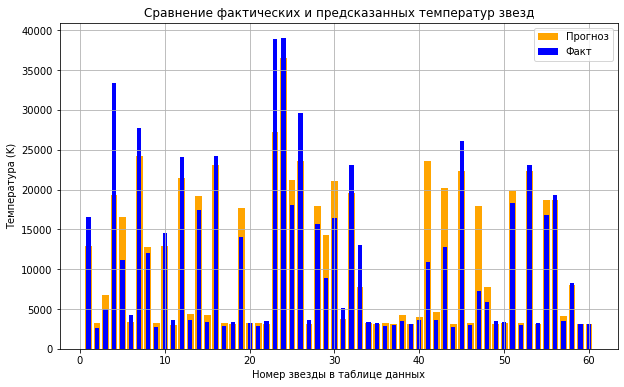

In [36]:
# Выведем график сравнения результатов лучшей нейронной сети после добавления нормализации батчей
plot_results(y_test, best_y_pred)

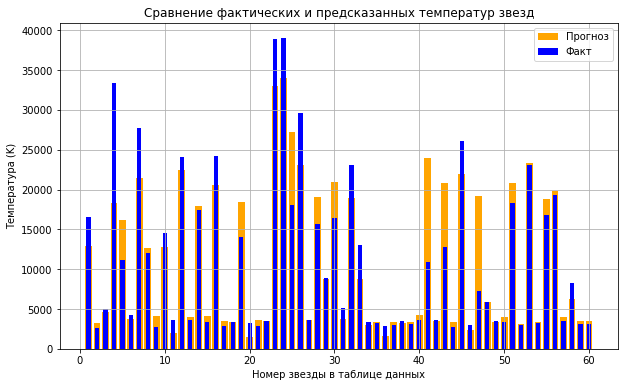

In [37]:
# Выведем график сравнения результатов базовой нейронной сети
plot_results(y_test, y_pred)

По результатам применения нормализации батчей лучшие параметры оказались при:
<br>Dropout: 0.0
<br>Batch Size: 60
<br>Достигнутый RMSE: 3937.88
<br><br>
В таблице с результатами видно, что наилучшие метрики уже у batch_sizes = 60 и batch_sizes = 90, что вероятно свидетельствует о незначительном влиянии гиперпараметра Batch Size в целом на метрики RMSE, а выявленные различия обусловлены выбранным SEEMS.
<br>
Dropout, в свою очередь, опять не оказал существенного влияния на качество нейронной сети.
<br>
Графики визуально отличаются незначительно, но отличия имеются. Улучшилось прогнозирование в зоне высоких и средних температур.

## Выводы

В процессе работы над проектом мы загрузили предоставленные данные, провели их предобработку и анализ. В процессе подготовки исправили опечатки в данных цвета звезд. Вывели матрицу корреляции, проанализировали корреляцию с целевым признаком. На основании корреляционного анализа определили подход к кодировке данных для нейронной сети.
<br><br>
С целью предсказания температуры звезд была создана базовая нейронная сеть, с двумя скрытыми слоями, с 8-ю и 5-ю нейронами соответствено. Лучшая метрика RMSE получена на 9000-й эпохе и составила 4303.6 К.
<br><br>
С целью повышения качества нейронной сети мы реализовали применение методов Dropout и Batch sizes с перебором гиперпараметров dropout_values = [0.0, 0.2, 0.4] batch_sizes = [30, 60, 90]. Этот подход не привел к существенному росту качества нейронной сети. 
<br>Лучшие параметры оказались при гиперпараметрах:
<br>Dropout: 0.4
<br>Batch Size: 30
<br>Достигнутый RMSE: 4254.6
<br><br>
Далее добавили нормализацию батчей в скрытые слои нейронной сети. Это существенно повысило ее качество. Достигнутый RMSE составил 3937.88 К. Именно данная реализация нейронной сети рекомендуется к применению.
<br><br>
В задании к проекту указан целевой уровень метрики RMSE на уровне 4500 К. Благодаря разумному подходу к предобработке данных и к кодированию категориальных признаков данный уровень был с запасом превзойден даже базовой моделью нейронной сети. Применение методов Dropout и Batch sizes с перебором гиперпараметров не повысило качество модели, а незначительный рост качества по RMSE (около 50 К) обусловлен скорее выбранным значением SEEMS (для воспроизводимости результатов). Применение нормализации батчей позволило снизить RMSE более чем на 300 К, что можно признать отличным результатом.
<br><br>
Также необходимо отметить сильную несбалансированность данных по некоторым признакам и очень малый объем предоставленных данных. Датасет на 240 строк и при таком содержании не позволяет получить репрезентативную тестовую выборку при test_size=0.2. Необходимо выбирать test_size=0.25, иначе не получить корректные метрики RMSE при прохождении по эпохам. О репрезентативной валидационной выборке и при этом достаточной тренировочной выборке и говорить не приходится. Поэтому рекомендуется обогатить исходный набор данных для ликвидации несбалансированности в данных и реализации подхлда с репрезентативной валидационной выборкой.